# Tiktok Task #1: MLDA DLW Hackathon

Members: Ng Zheng Xun (CSC Y4), Kevin Hu (EEE Masters), Lyu XingXiao (EEE Masters)

This notebook is split into several sections for easier readability:

- **Loading and Parsing** given Json data
- **Automating the Download** of videos using YTDL
- Splitting the Youtube videos according to timestamps given using provided Python script
- Using a **State-of-the-Art (SOTA) Video Captioning model Video-ChatGPT to generate a "groundtruth" caption**
    -  VideoChatGPT combines a pretrained visual encoder using CLIP, and a LLM (LLaVA-7B-Lightening-v1-1). We obtain the latter from HuggingFace.
    -  VideoChatGPT obtains SOTA performance on several video captioning benchmarks, such as VideoInstruct (*paperswithcode.com/sota/video-based-generative-performance?p=video-chatgpt-towards-detailed-video*)
-  **Generating a semantic similarity score** between the groundtruth caption generated in the previous step, against the provided caption from the noisy TikTok dataset. We use another model (a wrapper around ChatGPT3.5-turbo) to do so. The approach is based on the paper *Quantitative Evaluation Framework for Video-based Conversational Models, 2023*
    -  Other metrics were considered (such as n-grams matching/overlap), but **we focus on *semantic* similarity instead of *syntatic* similarity**. This is important as there are >1 ways to express the same idea in natural language, therefore syntatic similarity metrics are not a good method to evaluate the provided caption.
-  **Sorting and Filtering** the provided dataset of 1M captions, to retain the top 10% based on the scoring metric above
    -  This was not implemented due to constraints of time and computation. A toy example of 4 video snippets are provided instead, to illustrate the pipeline and scoring metrics above
 
 
--

#### Several general notes for our approach:
- To achieve the aim of lowering carbon emissions, we download videos and process them in a **low resolution format**. This saves computation power in downloading, processing, and running ML models on them.
- Several steps above (running and scoring the videos) were not run on Jupyter Notebook platform, and therefore the code can't be reproduced. However, efforts were made to provide relevant screenshots, command line commands, and relevant literature links for reference and understanding.
- Due to the **sheer size of the dataset provided, and our team's lack of GPUs**, we could only demostrate the above pipeline **using a toy dataset of 4 extracted video snippets**. However, we firmly believe that our processes and setup is implementable for a larger dataset, if provided access to stronger GPUs/more time.

## Loading and Parsing Json

Extracting youtube links and video ID from json file, and saving it as 3 seperate text files, for multiprocessing

Note to Reader: multiprocessing was ultimately not implemented due to time constraints, and the lack of GPU processing

In [4]:
import json

# process json to retreive all youtube urls
json_file = 'mlda_data.json'

with open(json_file, 'r') as j:
     contents = json.loads(j.read())

In [10]:
all_urls = []

for key in contents.keys(): # the video id, eg gpDB5250zfg
    #print(contents[key]['url']) # the url
    all_urls.append((key, contents[key]['url']))

In [11]:
print(len(all_urls))

18750


In [24]:
# split list into 3 .txt file for multi-processing

split_list = [all_urls[i:i + int(len(all_urls)/3)] for i in range(0, len(all_urls), int(len(all_urls)/3))]
print(len(split_list[0]))

6250


In [25]:
print(split_list[0])

[('44ot5_2UaaU', 'https://www.youtube.com/watch?v=44ot5_2UaaU'), ('1NRXqc74kQM', 'https://www.youtube.com/watch?v=1NRXqc74kQM'), ('1QFn-Yh2Y9k', 'https://www.youtube.com/watch?v=1QFn-Yh2Y9k'), ('3DlCGwJodqg', 'https://www.youtube.com/watch?v=3DlCGwJodqg'), ('-bmS0RumV9U', 'https://www.youtube.com/watch?v=-bmS0RumV9U'), ('1gul68uPqQk', 'https://www.youtube.com/watch?v=1gul68uPqQk'), ('4ZiwuL0K7KU', 'https://www.youtube.com/watch?v=4ZiwuL0K7KU'), ('3l7rn5SUxKs', 'https://www.youtube.com/watch?v=3l7rn5SUxKs'), ('19u_cK7r9P4', 'https://www.youtube.com/watch?v=19u_cK7r9P4'), ('1Fgquiy4Ob0', 'https://www.youtube.com/watch?v=1Fgquiy4Ob0'), ('0XGnU4ir5gs', 'https://www.youtube.com/watch?v=0XGnU4ir5gs'), ('3RG2ef12PM4', 'https://www.youtube.com/watch?v=3RG2ef12PM4'), ('3Ak9sZHUi9M', 'https://www.youtube.com/watch?v=3Ak9sZHUi9M'), ('4y52DCrkLeU', 'https://www.youtube.com/watch?v=4y52DCrkLeU'), ('5ADyVIcZHlo', 'https://www.youtube.com/watch?v=5ADyVIcZHlo'), ('2hAH4rE_kR4', 'https://www.youtube.co

In [30]:
# save to txt files
id = 0
for sublist in split_list:
    id += 1
    with open('urls_part_' + str(id) + '.txt', 'w') as f:
        for vid_id, url in sublist:
            f.write(f"{vid_id} {url}\n")

<!-- <div>
<img src=(attachment:9eb9ea77-363e-47ce-a37a-fdc6c8e54ad1.pngg" width="500"/>
</di -->

The resulting text file can be shown below:v>

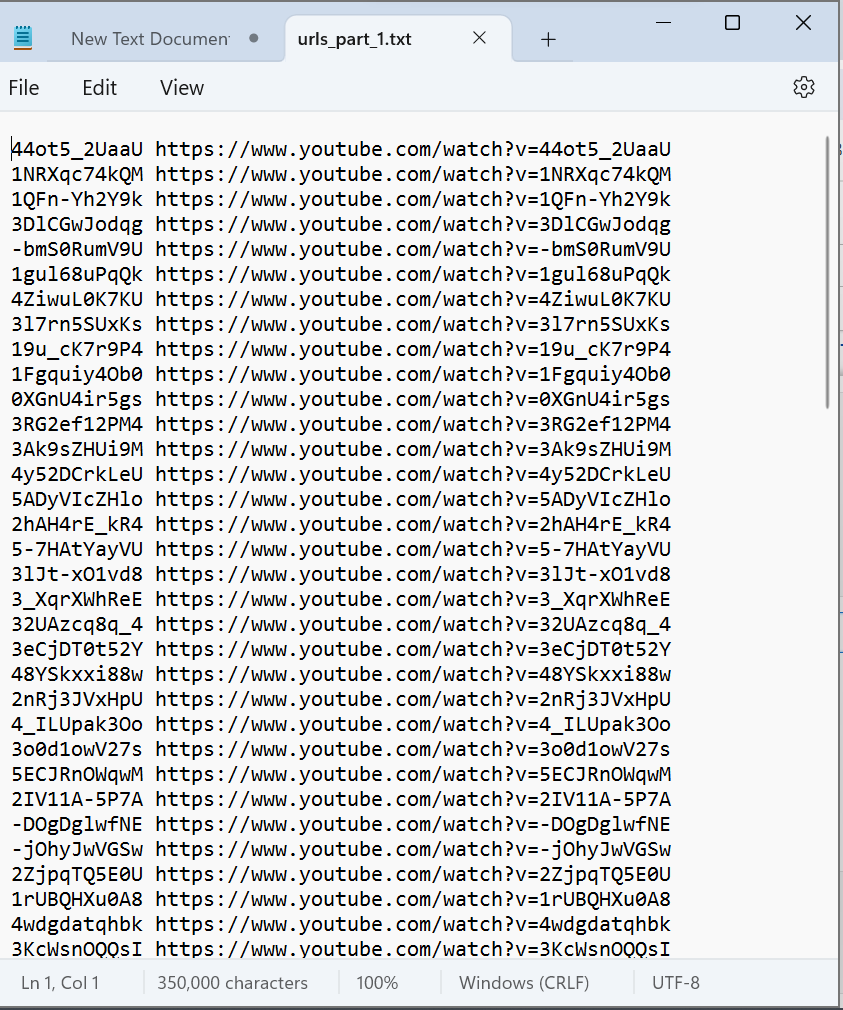

## Downloading Videos using ytdl
Reference: https://github.com/ytdl-org/youtube-dl/blob/master/README.md#embedding-youtube-dl 

To Install: ``pip install --upgrade youtube-dl``

In [1]:
import youtube_dl

# downloading videos from text files, and saving them in the format intended
txt_path = 'urls_part_1.txt'

In [ ]:
with open(txt_path) as file:
    for line in file:
        vid_id, url = line.split(" ")
        ydl_opts = {}
        with youtube_dl.YoutubeDL(ydl_opts) as ydl:
            ydl.download([url])

## Splitting Downloaded Videos using Python script

This was much less intensive due to the script provided. 


After some debugging and tweaking some variables, running the following command in the same directory as the python script would save the split videos in the /video_clips/[vid_ID] folder

`python cut_videos_mlda.py --metafile mlda_data.json --resultfile cut_part0.jsonl`

A screenshot of terminal running the splitting script for 1 video is shown below: several additional information is also printed out for better readibility

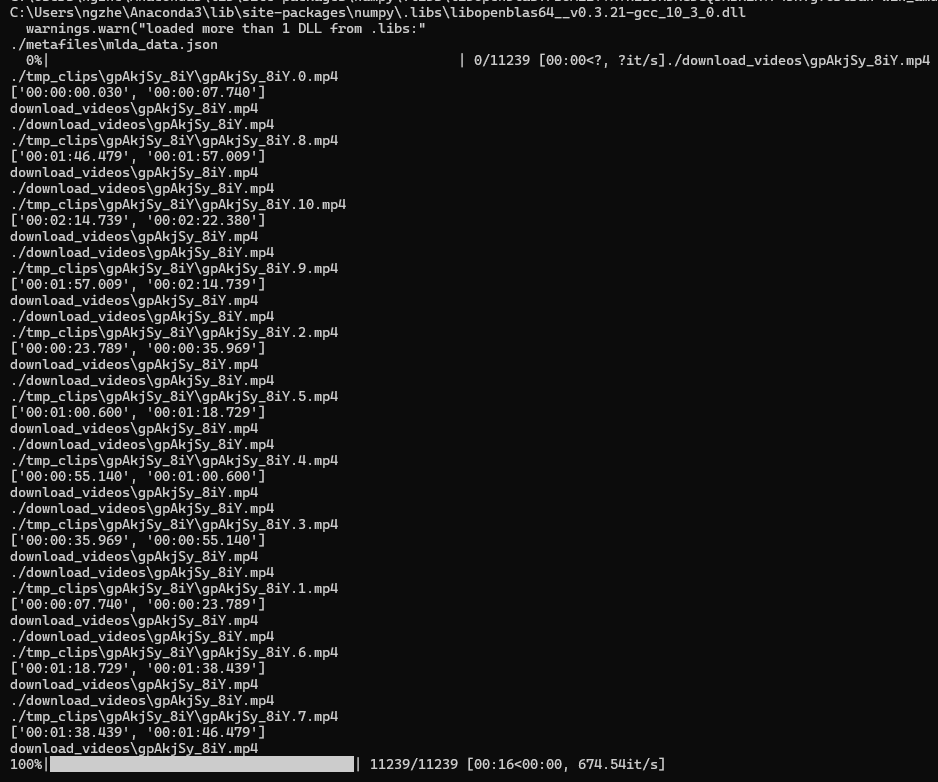

The file containing split videos are as shown:

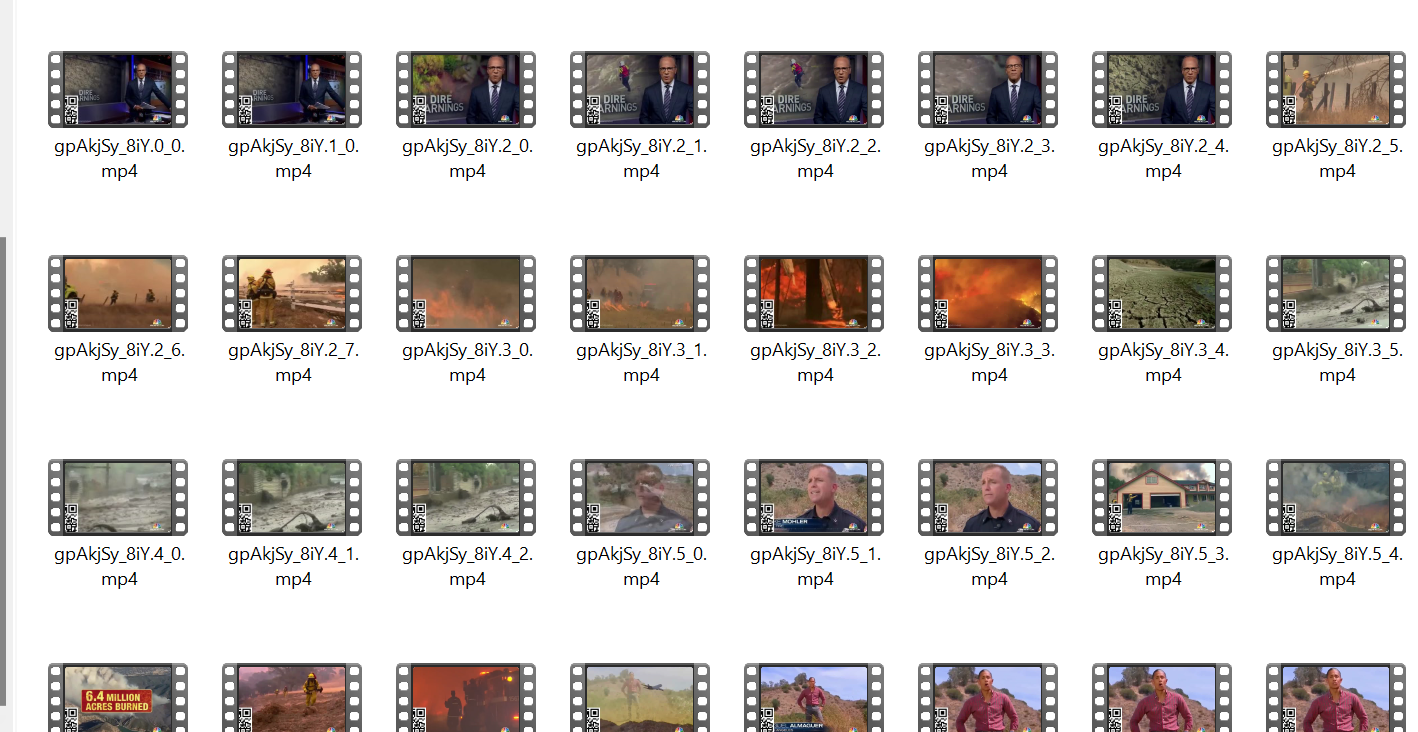

#### ** For the following sections, we take the FIRST FOUR videos from the above folder as our toy dataset to run inference on our SOTA models and generate the semantic similarity scores **

## Generate a "groundtruth" Caption with SOTA Video Captioning Model



We use a State-of-the-Art Video Captioning Model **VideoChatGPT** to **generate a groundtruth caption**. That is, we feed the model a video, and ask it to generate a description/caption. The model was chosen as **it gives SOTA and industry-leading results on several video captioning benchmarks, such as the VideoInstruct benchmark**, which could be viewed here: https://paperswithcode.com/sota/video-based-generative-performance?p=video-chatgpt-towards-detailed-video 

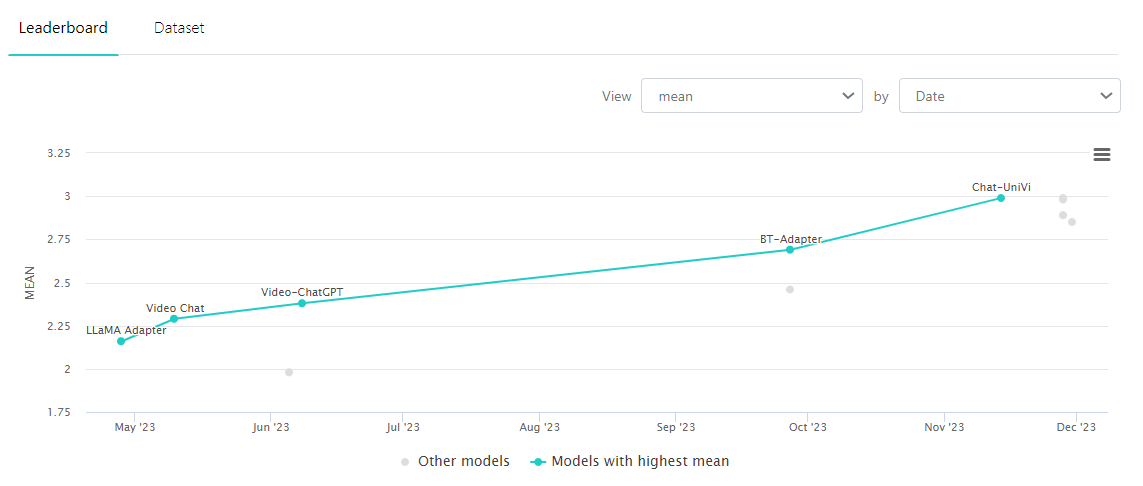


The model has several other functionalities such as Question-Answering based on a video, but **we focus on the Video Captioning instead**. Interestingly, the original authors approached the Video Captioning task as a variation of Question-Answering, whereby the question is simply the provided noisy caption. 


There were **significant difficulties in setting up a suitable environment, and to get the model running. Fortunately, we were able to overcome these difficulties, and the model managed to generate several inferences on the toy dataset.** Several changes were made to the source code as well, including optimising the model to run on a cpu environment.

The SOTA model is split into 2 parts, a pretrained visual encoder using CLIP, and a LLM (LLaVA-7B-Lightening-v1-1). **We obtain both pretrained model weights from HuggingFace**: the former from https://huggingface.co/MBZUAI/Video-ChatGPT-7B, and the latter from https://huggingface.co/mmaaz60/LLaVA-7B-Lightening-v1-1. 

Several other models were considered, such as mPLUG-2 by Alibaba, but were ultimately not implemented due to time constraints. Ideally, we hoped to be able to do a comparison between the 2 models.

To run the model, a local environment has to be set up, with the relevant weights of 2 sub-models being downloaded and set up. 

The final command to run the model inference functionality is the following:

`
python Video-ChatGPT/video_chatgpt/eval/run_inference_benchmark_general.py \
    --video_dir video_clips/gpAkjSy_8iY \
    --gt_file hdvg_results/cut_part0.jsonl \
    --output_dir output_prediction \
    --output_name prediction_1.json \
    --model-name LLaVA-7B-Lightening-v1-1 \
    --projection_path Video-ChatGPT/weights/video_chatgpt-7B.bin
`

On our machines, the inference of 1 video snippet takes around 40-50 minutes to run, which is a significant bottleneck. Therefore, we focus on the toy dataset.

A snippet of the bash terminal when running is shown:



It finally generates a consolidated output in a json file as shown:

In [8]:
json_file = [
  {
    "clip": "gpAkjSy_8iY/gpAkjSy_8iY.0_0.mp4",
    "caption": "a man in a suit and tie standing next to a news desk",
    "pred": "The man in the suit and tie is standing next to a news desk, and he is talking to the camera. He is wearing a suit and tie, which suggests that he is likely a news reporter or a guest on a news show. He is talking about the news and providing information to the audience."
  },
  {
    "clip": "gpAkjSy_8iY/gpAkjSy_8iY.8_1.mp4",
    "caption": "a street that has power lines down on it",
    "pred": "The video shows a street with power lines down on it, and a man is talking about the situation. He is wearing a suit and tie and is standing in front of a news desk."
  },
  {
    "clip": "gpAkjSy_8iY/gpAkjSy_8iY.8_2.mp4",
    "caption": "a woman standing in the middle of a flooded street",
    "pred": "In the video, a woman is standing in the middle of a flooded street, surrounded by water. She is holding a microphone and speaking to the camera. The man in the suit is also speaking to the camera, and the news reporter is sitting in front of a desk. The news reporter is talking about the flood and the woman standing in the flooded street. The news reporter is also talking about the flood and the woman standing in the flooded street."
  },
  {
    "clip": "gpAkjSy_8iY/gpAkjSy_8iY.8_3.mp4",
    "caption": "a group of people standing around a car in a flooded street",
    "pred": "In the video, a group of people are standing around a car in a flooded street. The man in the suit is talking to the camera and explaining the situation. He is pointing to the flooded street and the car. The flooded street is a result of heavy rainfall, and the car is stuck in the water. The man is trying to help the car owner by providing information about the situation and possible solutions."
  }
]

## Generating a Semantic Similarity Score 

We base our approach on the paper Quantitative Evaluation Framework for Video-based Conversational Models, 2023 (https://mbzuai-oryx.github.io/Video-ChatGPT/) 


Theres a need to generate a semantic similarity score between the 2 captions ('caption' vs 'pred' in the json file above). As mentioned above, **we focus on *semantic* similarity instead of *syntatic* similarity**. As there are multiple ways to express the same idea in natural language. We ultimately opted for a ChatGPT3.5-turbo wrapper program, which asks ChatGPT to score the provided captions with the following prompt:

In [ ]:
question = json_file['caption']
answer = json_file['caption']
pred = json_file['pred']

Prompt_to_ChatGPT_wrapper = [
    {
        "role": "system",
        "content":
            "You are an intelligent chatbot designed for evaluating the detail orientation of generative outputs for video-based question-answer pairs. "
            "Your task is to compare the predicted answer with the correct answer and determine its level of detail, considering both completeness and specificity. Here's how you can accomplish the task:"
            "------"
            "##INSTRUCTIONS: "
            "- Check if the predicted answer covers all major points from the video. The response should not leave out any key aspects.\n"
            "- Evaluate whether the predicted answer includes specific details rather than just generic points. It should provide comprehensive information that is tied to specific elements of the video.\n"
            "- Consider synonyms or paraphrases as valid matches.\n"
            "- Provide a single evaluation score that reflects the level of detail orientation of the prediction, considering both completeness and specificity."
    },
    {
        "role": "user",
        "content":
            "Please evaluate the following video-based question-answer pair:\n\n"
            f"Question: {question}\n"
            f"Correct Answer: {answer}\n"
            f"Predicted Answer: {pred}\n\n"
            "Provide your evaluation only as a detail orientation score where the detail orientation score is an integer value between 0 and 5, with 5 indicating the highest level of detail orientation. "
            "Please generate the response in the form of a Python dictionary string with keys 'score', where its value is the detail orientation score in INTEGER, not STRING."
            "DO NOT PROVIDE ANY OTHER OUTPUT TEXT OR EXPLANATION. Only provide the Python dictionary string. "
            "For example, your response should look like this: {''score': 4.8}."
    }
]

And we run the above wrapper program using the following command:

`python quantitative_evaluation/evaluate_benchmark_1_correctness.py \
    --pred_path ../output_prediction/prediction_1.json.json \
    --output_dir correctness_eval \
    --output_json correctness_eval/correctness.json \
    --api_keyXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXNpKT \
    --num_ta`
sks 1

The OpenAI Key above is masked.

Several sample output scores json file is shown below:

In [14]:
results = []
result_1 = [{"score": 5}, {"q": "a man in a suit and tie standing next to a news desk", "a": "a man in a suit and tie standing next to a news desk", "pred": "The man in the suit and tie is standing next to a news desk, and he is talking to the camera. He is wearing a suit and tie, which suggests that he is likely a news reporter or a guest on a news show. He is talking about the news and providing information to the audience."}]
print(result_1)
results.append(result_1)

[{'score': 5}, {'q': 'a man in a suit and tie standing next to a news desk', 'a': 'a man in a suit and tie standing next to a news desk', 'pred': 'The man in the suit and tie is standing next to a news desk, and he is talking to the camera. He is wearing a suit and tie, which suggests that he is likely a news reporter or a guest on a news show. He is talking about the news and providing information to the audience.'}]


In [15]:
result_2 = [{"score": 3}, {"q": "a street that has power lines down on it", "a": "a street that has power lines down on it", "pred": "The video shows a street with power lines down on it, and a man is talking about the situation. He is wearing a suit and tie and is standing in front of a news desk."}]

print(result_2)
results.append(result_2)

[{'score': 3}, {'q': 'a street that has power lines down on it', 'a': 'a street that has power lines down on it', 'pred': 'The video shows a street with power lines down on it, and a man is talking about the situation. He is wearing a suit and tie and is standing in front of a news desk.'}]


In [16]:
result_3 =[{"score": 2}, {"q": "a woman standing in the middle of a flooded street", "a": "a woman standing in the middle of a flooded street", "pred": "In the video, a woman is standing in the middle of a flooded street, surrounded by water. She is holding a microphone and speaking to the camera. The man in the suit is also speaking to the camera, and the news reporter is sitting in front of a desk. The news reporter is talking about the flood and the woman standing in the flooded street. The news reporter is also talking about the flood and the woman standing in the flooded street."}]

print(result_3)
results.append(result_3)

[{'score': 2}, {'q': 'a woman standing in the middle of a flooded street', 'a': 'a woman standing in the middle of a flooded street', 'pred': 'In the video, a woman is standing in the middle of a flooded street, surrounded by water. She is holding a microphone and speaking to the camera. The man in the suit is also speaking to the camera, and the news reporter is sitting in front of a desk. The news reporter is talking about the flood and the woman standing in the flooded street. The news reporter is also talking about the flood and the woman standing in the flooded street.'}]


--

After a few rounds of experimenting, we ran into `openai.error.RateLimitError: You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors`

And we decided to stop here for the running and usage of the models, as the **above results from the model shows that the pipeline is functional, and operates as intended.**

## Sorting of Results

We can then easily sort the results obtained by score and extract the top 10% with the best scores. This is rather trivial, but is nonetheless implemented below for completeness.

In [23]:
results.sort(key=lambda x: x[0]['score']) # sort in ascending order
results.reverse() # reverse to get highest score first

In [24]:
print(results)

[[{'score': 5}, {'q': 'a man in a suit and tie standing next to a news desk', 'a': 'a man in a suit and tie standing next to a news desk', 'pred': 'The man in the suit and tie is standing next to a news desk, and he is talking to the camera. He is wearing a suit and tie, which suggests that he is likely a news reporter or a guest on a news show. He is talking about the news and providing information to the audience.'}], [{'score': 3}, {'q': 'a street that has power lines down on it', 'a': 'a street that has power lines down on it', 'pred': 'The video shows a street with power lines down on it, and a man is talking about the situation. He is wearing a suit and tie and is standing in front of a news desk.'}], [{'score': 2}, {'q': 'a woman standing in the middle of a flooded street', 'a': 'a woman standing in the middle of a flooded street', 'pred': 'In the video, a woman is standing in the middle of a flooded street, surrounded by water. She is holding a microphone and speaking to the ca

In [27]:
top_10_percent = results[int(len(results)*0.1)]
print(top_10_percent)

[{'score': 5}, {'q': 'a man in a suit and tie standing next to a news desk', 'a': 'a man in a suit and tie standing next to a news desk', 'pred': 'The man in the suit and tie is standing next to a news desk, and he is talking to the camera. He is wearing a suit and tie, which suggests that he is likely a news reporter or a guest on a news show. He is talking about the news and providing information to the audience.'}]
